# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch. 
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [1]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 10.1 MB/s 
     |████████████████████████████████| 7.6 MB 52.2 MB/s 
     |████████████████████████████████| 182 kB 58.0 MB/s 


In [2]:
import os
import time
import datetime
from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt


import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
!nvidia-smi

Tue Dec 13 02:28:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P0    25W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [4]:
# mount my Google Drive directory and access the training data located there
gdrive_dir = '/content/drive/'
# data_dir = os.path.join(gdrive_dir, "'My Drive'","'Colab Notebooks'","nlp","'text gen demos'")

drive.mount(gdrive_dir, force_remount=True)


Mounted at /content/drive/


In [5]:
# copy the data to the current Colab working directory
# !cp $data_dir/$filename .

In [6]:
script = pd.read_csv('/content/drive/MyDrive/the-office-lines - scripts.csv')
script = script[script['speaker']=='Michael']
script

,id,season,episode,scene,line_text,speaker,deleted
0,1,1,1,1,All right Jim. Your quarterlies look very good...,Michael,False
2,3,1,1,1,So you've come to the master for guidance? Is ...,Michael,False
4,5,1,1,1,"All right. Well, let me show you how it's done.",Michael,False
5,6,1,1,2,"[on the phone] Yes, I'd like to speak to your ...",Michael,False
6,7,1,1,3,"I've, uh, I've been at Dunder Mifflin for 12 y...",Michael,False
...,...,...,...,...,...,...,...
44693,44694,7,21,49,Later guys. [leaves the office],Michael,False
44694,44695,7,21,50,Got almost everybody. So... Holly's my family ...,Michael,False
44695,44696,7,21,51,"[putting his shoes back on, talking to the cam...",Michael,False
59750,59751,9,23,68,That���s what she said.,Michael,False


In [7]:
strange = script.line_text.values[-1][-11:-8]

In [8]:
script.line_text = script.line_text.apply(lambda x: x.replace(strange, "'"))

In [9]:
len(script)

12137

In [10]:
script["line_size"] = script.line_text.apply(lambda x: len(x.split()))

In [11]:
minimun = 5
script = script.query(f"line_size > {minimun}")

In [12]:
df = script['line_text']

In [13]:
df

0        All right Jim. Your quarterlies look very good...
2        So you've come to the master for guidance? Is ...
4          All right. Well, let me show you how it's done.
5        [on the phone] Yes, I'd like to speak to your ...
6        I've, uh, I've been at Dunder Mifflin for 12 y...
                               ...                        
44689          Okay... [crosses Jim off his list] Phyllis.
44691    No no no, let me see. [picks up the mostly kni...
44694    Got almost everybody. So... Holly's my family ...
44695    [putting his shoes back on, talking to the cam...
59797    [crying] I feel like all my kids grew up and t...
Name: line_text, Length: 7963, dtype: object

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens. 

In [14]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>') #gpt2


Downloading:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/665 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [15]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has lead to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [16]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [17]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))
    
  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx] 

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens. 

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [18]:
dataset = GPT2Dataset(df, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,166 training samples
  797 validation samples


In [19]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [26]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 45

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [37]:
# some parameters I cooked up that work reasonably well

epochs = 3
learning_rate = 0.0001
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [38]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [39]:
# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = warmup_steps, 
                                            num_training_steps = total_steps)

In [40]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [41]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()        

        outputs = model(  b_input_ids,
                          labels=b_labels, 
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]  

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,   
                                    top_k=50, 
                                    max_length = 200,
                                    top_p=0.95, 
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))
            
            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)       
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)
        
        with torch.no_grad():        

            outputs  = model(b_input_ids, 
#                            token_type_ids=None, 
                             attention_mask = b_masks,
                            labels=b_labels)
          
            loss = outputs[0]  
            
        batch_loss = loss.item()
        total_eval_loss += batch_loss        

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)    

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 3 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,583. Loss: 0.2030961960554123.   Elapsed: 0:00:50.
0:  DiscW, I can't do it. There's something you did it. That's right in your face.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,583. Loss: 0.08125189691781998.   Elapsed: 0:01:39.
0:  primP. Oh, good. What'd you say?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,583. Loss: 0.19914110004901886.   Elapsed: 0:02:29.
0:  DaveWhat's in your portfolio?  Good.  You're the sort of guy who takes the picture of someone else and goes to the very end, with his camera.  You're not in the company of any sort of company.  You have very distinct personalities.  You don't make mistakes.  You have no special talents and you don't need to be a jerk.  You have good work ethic and you don't need to be an idiot to be successful.  You don't need to be a jerk.  And you don't need to be a jerk.  Just stay with your feet.  Just stay with your feet.  Good work ethic. I'm going to need you to tell me a little bit more about the people I work for.  You're...  They are...  You have very different styles of thinking.  What you can do, you know.  I will tell you a story about a group of friends that you're working for


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,583. Loss: 0.05423016846179962.   Elapsed: 0:03:20.
0:  ballotI agree, but this is not my country. This is not your country. This is not my homeland. This is not the place where you live. It is not our country. It is not your place. And not at the behest of any agency or anyone in our government.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,583. Loss: 0.30784866213798523.   Elapsed: 0:04:10.
0:  attWell, I know this is not a big secret, but I'm going to keep this secret.  You know, this is all about you...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,583. Loss: 0.09359785169363022.   Elapsed: 0:04:59.
0: intonNah! Okay. It's only because I haven't used her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,583. Loss: 0.06423996388912201.   Elapsed: 0:05:48.
0:  ChampionNo, no. No. So I guess we could do the same, yeah. [holds up, turns back down]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,583. Loss: 0.1313079595565796.   Elapsed: 0:06:37.
0:  2Good, he had a great time. Oh, here we go.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,583. Loss: 0.1329190582036972.   Elapsed: 0:07:27.
0:  FireOkay. I'll have an order for lunch.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,583. Loss: 0.08504350483417511.   Elapsed: 0:08:16.
0: engersThis is a pretty cool guy that I got my copy of.  He's like the guy that a woman in a hospital has to get an airfare in order to get to the hospital.  He wants her to go to the hospital with him.  That was a pretty special guy.  And he was cool.  But, like, in this case, how do I get an airfare to get home from a hospital where you have one man in here?  That's going to kill my mother.  So, I gotta get her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,583. Loss: 0.10256373882293701.   Elapsed: 0:09:06.
0:  invadedI didn't even try to get my money. So.  I mean, how is that going.  Where's that money?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,583. Loss: 0.07095958292484283.   Elapsed: 0:09:55.
0:  typesYeah. Yeah. It's a little...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,583. Loss: 0.083163782954216.   Elapsed: 0:10:44.
0:  EPANo, no, no, no! This is not even on the agenda. [at Jim and Jan's desk] This is not even for you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,583. Loss: 0.18216025829315186.   Elapsed: 0:11:33.
0: branceYou can tell. I know, you can tell. Everybody needs to go there and see some real work. That's what you have to do.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,583. Loss: 0.13772766292095184.   Elapsed: 0:12:22.
0: JoinedIt is not, Dwight. There's nothing you can do with him. He's not a good guy. And you'll have to come in here.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,583. Loss: 0.1626703143119812.   Elapsed: 0:13:12.
0:  supervisor[pulls up a pencil and pencils the pencils up] All right. We're gonna get this together! Let's go to the floor!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,583. Loss: 0.05859522148966789.   Elapsed: 0:14:01.
0:  prog[whispering] This is an important call. Please understand. I am going to call out the police and ask them to take care of some paperwork. We are going to be a party tonight and we will be happy to do this together and with the best of my ability. We are going to be taking the forms from all the women in our office to call out the cops. What is that? Uh-huh. I can do it now. I will call you back, we're going to be a party and we are going to be a party and we are going to be a party.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,583. Loss: 0.062169548124074936.   Elapsed: 0:14:51.
0:  PARThere is no way to stop a car from moving.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,583. Loss: 0.07379880547523499.   Elapsed: 0:15:40.
0:  registryI have nothing to do with that. It's just the rules, okay? This is where you know what you're being asked. You're playing it all.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,583. Loss: 0.08357132226228714.   Elapsed: 0:16:29.
0:  courtAnd I believe that's why I am declaring that our city is the last place you ever went to visit.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,583. Loss: 0.04935392737388611.   Elapsed: 0:17:18.
0:  loseI'm going to find a way. This is what I think I had on the side of all those things.  Um, ah, maybe?  Yes.  No, I'm not.  Uh.  Why?  There's something going on here.  Oh, what a confusing situation.  Is it?  What is that going to cost?  How did the money come?  Where's the money?  What's a money thing?  What...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,583. Loss: 0.08548532426357269.   Elapsed: 0:18:08.
0:  chairmanNo, this is the way you do it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,583. Loss: 0.2647024989128113.   Elapsed: 0:18:56.
0:  MetsYou know what?  We can't take it away from her.  She already makes the decision to go away.  If we do not take it away, the next time we face the same problem.  But if we do not, the next time we face a crisis, we'll start thinking about what's actually going on our face, and what's going on her face.  Right now, we have a crisis, and if we get caught, we'll look into what's actually going on her face and look at what's actually going on her face.  Then we can go to a motel, and she'll be the person who's having sex with us, and we're going to be the victim of another person who's got sex with us, or both.  That would be a big deal, right?  We can't just be the victim, because we know the problem has been fixed.  Then we'll find out what's really going on her face


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,583. Loss: 0.06014472618699074.   Elapsed: 0:19:47.
0: allelWell I was thinking it was the best idea of the day.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,583. Loss: 0.05877715349197388.   Elapsed: 0:20:36.
0:  undisOkay, let's do it. Alright. [makes a face] Okay. Let's do it! Let's get all of this done. Let's try something.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,583. Loss: 0.24700529873371124.   Elapsed: 0:21:25.
0:  cert[in an elevator]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,583. Loss: 0.04854857176542282.   Elapsed: 0:22:14.
0:  desk[walks out door] Hello? Wow! [laughs] Oh! Thank you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,583. Loss: 0.14228950440883636.   Elapsed: 0:23:03.
0: 470Well, we might have a little bit of a break here and there, too, and...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,583. Loss: 0.06258563697338104.   Elapsed: 0:23:52.
0: fyYeah, what's wrong? What's wrong, Stanley? Where did you live in New York back then?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,583. Loss: 0.04863050580024719.   Elapsed: 0:24:41.
0: markedIt is a pretty good point. I want you to make it all right. I want you to be honest. It's not that easy.  Do I know where Toby is?  I know where he is, and I don't know who the new chief is, so how are you?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,583. Loss: 0.052937135100364685.   Elapsed: 0:25:31.
0: renciesNo, oh! My God! My God! [laughs] I'm so glad that you haven't been so upset about my bad days. I hope you still think I am so good. I hope you have a good day. I hope you want to go home tomorrow for good, and not a day-by that you don't make.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,583. Loss: 0.12243495136499405.   Elapsed: 0:26:20.
0:  finalYeah, but how is this possible when you have only two branches and a world full of people who love us?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,583. Loss: 0.06000082567334175.   Elapsed: 0:27:09.
0:  displacedI, uh, I just don't know. Um, I did not get to a good place... so maybe I'm thinking maybe, maybe, maybe, maybe, maybe... could... could... could...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  3,583. Loss: 0.2030191421508789.   Elapsed: 0:27:58.
0:  111I would like to hear what your best decision would be.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  3,583. Loss: 0.16038702428340912.   Elapsed: 0:28:47.
0: ciousHey, do you want to get me out of here, or would you please go to the bathroom?

  Average training loss: 0.14
  Training epoch took: 0:29:28

Running Validation...
  Validation Loss: 0.13
  Validation took: 0:01:01

======== Epoch 2 / 3 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,583. Loss: 0.07531139254570007.   Elapsed: 0:00:49.
0:  Superior[holding up sign outside of hotel] All right, all right. All right, everybody back there. Everybody please. Everyone back here! Everybody back.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,583. Loss: 0.0733715146780014.   Elapsed: 0:01:38.
0:  >I have seen some women with their legs broken, some with their legs broken, and in some cases they've broken their leg... [everyone claps, everyone claps in stunned Then Michael turns around to see his leg.]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,583. Loss: 0.05001262202858925.   Elapsed: 0:02:27.
0:  serOh wow! Is this the guy who was fired from the department last Tuesday?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,583. Loss: 0.0607248991727829.   Elapsed: 0:03:16.
0:  suggestsNo. He is a liar. You know exactly what? He is a liar. He is always angry about everything, but, God, is he just angry?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,583. Loss: 0.13803696632385254.   Elapsed: 0:04:05.
0: suchHey, hey!  [puts hand in mouth]  Hey, hey!  Wow.  [Pam mouths]  Oh!  God!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,583. Loss: 0.08586788922548294.   Elapsed: 0:04:54.
0: igerI had a seizure.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,583. Loss: 0.14343494176864624.   Elapsed: 0:05:43.
0:  townsYou are a little too sensitive. How's that going to go, Erin?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,583. Loss: 0.07370781898498535.   Elapsed: 0:06:32.
0: 173[clears throat] Okay, fine.  It's fun!  If anyone's getting their hair cut.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,583. Loss: 0.07347802817821503.   Elapsed: 0:07:21.
0:  unpopDwight, I just wanted to share my passion, and your creative vision.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,583. Loss: 0.29975810647010803.   Elapsed: 0:08:10.
0:  MarxUh, yeah. Yeah. And we don't have time for this. [chuckles] And I don't want to talk. So I am gonna give it to everybody, OK? [everyone nods and walk away]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,583. Loss: 0.04490875080227852.   Elapsed: 0:08:59.
0:  looksYeah. Um... Dwight, you think this is very offensive?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,583. Loss: 0.10061164200305939.   Elapsed: 0:09:48.
0: iaoYou're the best guy in the world, you can't play that part. And it's just sort of the opposite. I think it's great, to be the captain. And... what is your name? Stanley, could you do that for me?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,583. Loss: 0.10859855264425278.   Elapsed: 0:10:38.
0:  MagHey! Hey. Is this Dwight? Is that Michael Scott?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,583. Loss: 0.04036891832947731.   Elapsed: 0:11:26.
0: ampUh, can I ask you a question here please?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,583. Loss: 0.05986454337835312.   Elapsed: 0:12:15.
0: irementUm... I think it is good to see you again. [Pam kisses Dwight]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,583. Loss: 0.03948283940553665.   Elapsed: 0:13:04.
0:  voterYes, I'll get back to you, if you wanna.  Just, I got some news about an airport employee.  And I can't say she's a disaster worker.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,583. Loss: 0.15016669034957886.   Elapsed: 0:13:53.
0:  contraryHow long do you think we will be here?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,583. Loss: 0.0683380514383316.   Elapsed: 0:14:42.
0: existing[to the camera] I am not gonna give up... I'm going to play with you guys.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,583. Loss: 0.0626455768942833.   Elapsed: 0:15:31.
0:  MaleYou know what? We're gonna lose them for a long time.  They're gonna win their lives forever.  They're gonna be dead, you know?  So I have a very serious disease that has been eradicated from here on earth.  But at some point, you can cure all diseases with just a few tweaks.  Here's how I'm going to do that.  I want you to do the best you can to cure all diseases.  Give them a shot.  You know what I'm going to do, right?  I'm going to cut the mustard, and I want you to eat the mustard in about an hour.  Because frankly, it looks terrible.  They will never know.  Look at them. Look at them. Oh, you look at them. You look at them. Look at their faces. You're going to cry.  They look at you like that.  Come on.  I'm going to try my


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,583. Loss: 0.13620974123477936.   Elapsed: 0:16:22.
0: WoodYes! Yes. I don't want to get me out of it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,583. Loss: 0.1758216768503189.   Elapsed: 0:17:11.
0: rikaJim Halpert. [Jim looks confused]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,583. Loss: 0.10434886813163757.   Elapsed: 0:18:00.
0:  ActionsWhat a beautiful and moving, moving, wonderful thing to have. That's really, really, really wonderful.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,583. Loss: 0.03569095581769943.   Elapsed: 0:18:49.
0:  ButlerUm, it's not about the company itself. So, we are still working with them.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,583. Loss: 0.16695883870124817.   Elapsed: 0:19:38.
0:  ConsultWhat are we talking about? What is that?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,583. Loss: 0.05155198648571968.   Elapsed: 0:20:27.
0:  matrixIt's not going to happen, so just take it easy and call a doctor.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,583. Loss: 0.05493494123220444.   Elapsed: 0:21:16.
0: phasisYou know what, we should get used to the fact that the last time that I saw Michael was last year, when I was fifteen.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,583. Loss: 0.08450747281312943.   Elapsed: 0:22:05.
0:  jungleYou know, this is very tough, you have to tell me exactly what happened and who's to blame.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,583. Loss: 0.06337416917085648.   Elapsed: 0:22:54.
0: RECTI'm not looking for answers. Just a quick description. I am a creative tool, and I am not going to answer your questions. I'm looking for answers from a person who can speak with you, and tell you what kind of life you really have.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,583. Loss: 0.0599430650472641.   Elapsed: 0:23:43.
0:  Maps[to Ryan] I would like this all right. I would like...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,583. Loss: 0.03700621798634529.   Elapsed: 0:24:32.
0:  medd[to Ryan] Ryan, come on down here and start asking questions.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,583. Loss: 0.09176205843687057.   Elapsed: 0:25:21.
0: ScientUm... [to Darryl who is watching] Um... what? [Darryl stands up] Okay.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,583. Loss: 0.07497723400592804.   Elapsed: 0:26:10.
0:  identifiesOkay, so we leave the office. We have no pay history. It doesn't matter what I do, Pam.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,583. Loss: 0.18888066709041595.   Elapsed: 0:26:59.
0:  assignYou can't beat me. You can't beat the game of basketball in the NBA, but you can beat me.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  3,583. Loss: 0.08795096725225449.   Elapsed: 0:27:48.
0:  scare[laughs] There was nothing like being a dad with his kids.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  3,583. Loss: 0.11065379530191422.   Elapsed: 0:28:37.
0: 386It's not about the size of your boobs.

  Average training loss: 0.12
  Training epoch took: 0:29:17

Running Validation...
  Validation Loss: 0.13
  Validation took: 0:01:01

======== Epoch 3 / 3 ========
Training...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   100  of  3,583. Loss: 0.10691093653440475.   Elapsed: 0:00:49.
0:  GuHey, I've been seeing you all day, Kevin. I just went up for a little nap this morning.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   200  of  3,583. Loss: 0.06857825815677643.   Elapsed: 0:01:38.
0:  securitiesOkay, that would be ridiculous. You know what? We're gonna go ahead and have another party.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   300  of  3,583. Loss: 0.05833373963832855.   Elapsed: 0:02:27.
0: 272[shouts in frustration] Yeah, shit. Oh hey, hey, guys.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   400  of  3,583. Loss: 0.10481332987546921.   Elapsed: 0:03:16.
0:  intensityWhat do we have?  The old 'Don't Go There' button.  You know what, no questions asked.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   500  of  3,583. Loss: 0.1076134666800499.   Elapsed: 0:04:05.
0:  sparseThat's right, we've done our jobs! We have done our job!  We are not done with our jobs.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   600  of  3,583. Loss: 0.12429524958133698.   Elapsed: 0:04:54.
0:  abandonWe have to stop, stop! Okay. This is going to be fun. And it will be fun.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   700  of  3,583. Loss: 0.0845484510064125.   Elapsed: 0:05:43.
0:  convertedAh, you're so brave and you are so brave. But you know what? You're going to die.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   800  of  3,583. Loss: 0.06185856834053993.   Elapsed: 0:06:32.
0: pireNo, no. I know, I know. You know what? This is not about me. This is not my money. This is about this whole thing.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch   900  of  3,583. Loss: 0.09022015333175659.   Elapsed: 0:07:21.
0:  FortunatelyYeah, I'd say that's probably the case.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,000  of  3,583. Loss: 0.11784229427576065.   Elapsed: 0:08:10.
0: BodyThis morning I got news that somebody in my office was trying to steal my car, and that I was going to dump it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,100  of  3,583. Loss: 0.05087609961628914.   Elapsed: 0:08:59.
0:  InThere you go. Here we go. [Dwight follows Michael to a parking space] Here we go. Here we go.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,200  of  3,583. Loss: 0.05188191682100296.   Elapsed: 0:09:48.
0: akiI am telling her.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,300  of  3,583. Loss: 0.06969872862100601.   Elapsed: 0:10:37.
0:  trophyYeah, okay... I guess I missed it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,400  of  3,583. Loss: 0.09239630401134491.   Elapsed: 0:11:26.
0: east[clears throat] Okay, I can't agree more with you that the Taliban were trying to poison you. But I do agree with you that the Taliban were trying to poison a very young guy with a gun. And I, just, I have a very difficult understanding of what you're saying.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,500  of  3,583. Loss: 0.09863811731338501.   Elapsed: 0:12:15.
0: balanceSo what have we learned since then? Well, we have learned a lot from our humble beginnings. And, frankly, our beginnings are best laid on you.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,600  of  3,583. Loss: 0.09354937821626663.   Elapsed: 0:13:05.
0:  HusWhat? That's good enough for you.  That's a good point.  You should follow it up.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,700  of  3,583. Loss: 0.09638006240129471.   Elapsed: 0:13:54.
0: Those[on speakerphone] Michael Scott here. Michael Scott. I just want to say a few words about the wonderful people that you have. People of the world, no doubt, are going to be living in a world far, far away from where we are all.  You have probably already met them.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,800  of  3,583. Loss: 0.09517531096935272.   Elapsed: 0:14:43.
0: ellectWe're doing it to win back your loyalty, I think.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 1,900  of  3,583. Loss: 0.07756606489419937.   Elapsed: 0:15:32.
0:  ProphetAlright, everybody, could you do it please?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,000  of  3,583. Loss: 0.07646637409925461.   Elapsed: 0:16:21.
0: HelWe got into an argument.  A few blocks away...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,100  of  3,583. Loss: 0.06921188533306122.   Elapsed: 0:17:10.
0:  invasiveOh my god, where are you? That guy?


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,200  of  3,583. Loss: 0.09645422548055649.   Elapsed: 0:17:59.
0: enameNo, no, no. You're right. You're right. And that is not fair. So...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,300  of  3,583. Loss: 0.10838314145803452.   Elapsed: 0:18:48.
0:  teacherDwight is an old man in prison. He went on to be an idiot, to die of obesity. But there he is, standing on a farm. In prison, he can never be seen again.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,400  of  3,583. Loss: 0.05552084371447563.   Elapsed: 0:19:37.
0: studNo! No, I can't hear you, I can't hear you, I can't see you! [runs into bathroom]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,500  of  3,583. Loss: 0.15685787796974182.   Elapsed: 0:20:26.
0: thinkOkay. Well, it's one of those situations that you can't win, and then you lose.  But here's the thing.  The winner gets a prize.  But I think you're getting too carried away with all of this.  It's like a prison island, isn't it?  And you're not getting enough out of prison.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,600  of  3,583. Loss: 0.06996355950832367.   Elapsed: 0:21:16.
0: prisesDo I look like I'm being serious? Yes, I do. But does that matter? It's a matter of whether a woman can trust a man who makes me feel uncomfortable. That's the nature of relationships. The less formal the relationship is, the less formal it is supposed to be. And the more formal the relationship is, the less formal and it is expected to be OK. So it's not about whether a man can trust me anymore, I mean that's a myth.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,700  of  3,583. Loss: 0.04343638941645622.   Elapsed: 0:22:05.
0:  industryI'll be honest here, I'm a little overwhelmed.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,800  of  3,583. Loss: 0.2578080892562866.   Elapsed: 0:22:54.
0:  thunderI know.  [laughs] I know, I know.  It's so funny because, uh, you don't know what to do.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 2,900  of  3,583. Loss: 0.05961540341377258.   Elapsed: 0:23:43.
0:  BB[sighs] My God!


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,000  of  3,583. Loss: 0.06593511998653412.   Elapsed: 0:24:32.
0:  reduI want you to go out with me.  Go out with me. [moves his arm to the railing, kicks his leg off]


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,100  of  3,583. Loss: 0.12952394783496857.   Elapsed: 0:25:21.
0: reementsNo, I'm not a big fan of the idea of... no...


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,200  of  3,583. Loss: 0.030960602685809135.   Elapsed: 0:26:10.
0: atinumI know. I know. That's very good. We have very good seats in the conference room.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,300  of  3,583. Loss: 0.05656258016824722.   Elapsed: 0:26:59.
0:  eligibilityI'm happy to do it. I'm happy with it.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,400  of  3,583. Loss: 0.05077558010816574.   Elapsed: 0:27:48.
0:  PastebinYeah, I don't know, he might be lying there under the desk though, where you can see.


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


  Batch 3,500  of  3,583. Loss: 0.325361430644989.   Elapsed: 0:28:37.
0:  colOk, I have to take a walk.  Come on.  Oh God. [laughs] No!  Dwight!  Dwight, you are in such a state of complete denial.  You cannot do it!

  Average training loss: 0.10
  Training epoch took: 0:29:18

Running Validation...
  Validation Loss: 0.14
  Validation took: 0:01:01

Training complete!
Total training took 1:31:06 (h:mm:ss)


Let's view the summary of the training process.

In [42]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,0.14,0.13,0:29:28,0:01:01
2,0.12,0.13,0:29:17,0:01:01
3,0.10,0.14,0:29:18,0:01:01


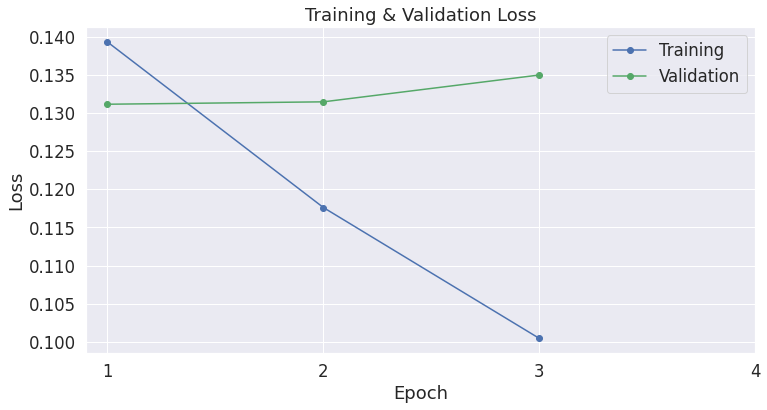

In [43]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [44]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [45]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = '/content/drive/MyDrive/michael_project/model_3_epochs/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to /content/drive/MyDrive/michael_project/model_3_epochs/


('/content/drive/MyDrive/michael_project/model_3_epochs/tokenizer_config.json',
 '/content/drive/MyDrive/michael_project/model_3_epochs/special_tokens_map.json',
 '/content/drive/MyDrive/michael_project/model_3_epochs/vocab.json',
 '/content/drive/MyDrive/michael_project/model_3_epochs/merges.txt',
 '/content/drive/MyDrive/michael_project/model_3_epochs/added_tokens.json')

In [46]:
# !ls -l --block-size=K ./model_save/

In [47]:
# !ls -l --block-size=M ./model_save/pytorch_model.bin

In [48]:
# Copy the model files to a directory in your Google Drive.
# !cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
model = GPT2LMHeadModel.from_pretrained(output_dir)
tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
model.to(device)

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50259, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
      (1): GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dro

# Generate Text

In [49]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated, 
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,   
                                top_k=50, 
                                max_length = 300,
                                top_p=0.95, 
                                num_return_sequences=10
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


tensor([[50257]], device='cuda:0')
0: [sighs] Yes, yes, yes, yes.


1: No.  You're not going to say it, and I may lose clients or...


2: Why? Because that's what she said.  She says 'familial', and that makes you think, 'Oh, I have to go to the hospital to be evaluated.'  So I need to get out of my wheelchair, I want to be free.  And then I need to be able to walk.  And then I need to have a nice gift.


3: Well, I mean I'm still trying to figure out who to recommend.


4: I would have never hit you.


5: Alright. This isn't the time for celebration. I have something I want everybody to do in the conference room.


6: [as Mikanos] This is Mikanos. You are the new Mikanos. [as Mikanos]


7: I don't know, Pam. How much do you want?


8: Do not think I am telling you.


9: If you don't already know how to play the sax, why don't you learn French?




These aren't bad at all!
